<a href="https://colab.research.google.com/github/N8uce/Association-rules/blob/main/%D0%90%D0%BD%D0%B0_%D0%94%D0%B0%D0%BD%D0%BD%D1%8B%D1%85_%D0%9B%D0%A01_%D0%95%D1%84_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Предобработка данных

In [2]:
import pandas as pd
import re

file_path = '/content/drive/MyDrive/access.log'

# Считывание лог-файла
with open(file_path, 'r') as f:
    logs = f.read().split('\n')

data = []
for log in logs:
    match = re.search(r'(\d+\.\d+\.\d+\.\d+) - - \[(.*?)\] "(.*?)" (\d+) (\d+) (ID\d+)', log)
    if match:
        data.append(match.groups())

# Преобразование данных в DataFrame
df = pd.DataFrame(data, columns=['ip', 'date', 'request', 'status', 'size', 'id'])
df

,ip,date,request,status,size,id
0,7.234.2.41,1/Apr/2015:00:00:01 +04:00,POST /catalog.phtml HTTP 1.1,200,3656,ID4864
1,1.90.236.143,1/Apr/2015:00:00:03 +04:00,POST /catalog.phtml HTTP 1.1,200,4444,ID4845
2,82.185.18.119,1/Apr/2015:00:00:20 +04:00,POST /search.phtml HTTP 1.1,200,3957,ID4850
3,196.1.37.239,1/Apr/2015:00:00:53 +04:00,POST /search.phtml HTTP 1.1,200,3743,ID4830
4,190.190.84.47,1/Apr/2015:00:01:05 +04:00,POST /search.phtml HTTP 1.1,200,3072,ID4833
...,...,...,...,...,...,...
233710,70.229.213.216,30/Apr/2015:23:58:52 +04:00,POST /search.phtml HTTP 1.1,200,2530,ID54373
233711,156.62.152.61,30/Apr/2015:23:59:02 +04:00,POST /catalog.phtml HTTP 1.1,200,3708,ID54331
233712,225.210.160.165,30/Apr/2015:23:59:08 +04:00,POST /search.phtml HTTP 1.1,200,3588,ID54354
233713,197.121.165.116,30/Apr/2015:23:59:34 +04:00,POST /catalog.phtml HTTP 1.1,200,3080,ID54360


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233715 entries, 0 to 233714
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   ip       233715 non-null  object
 1   date     233715 non-null  object
 2   request  233715 non-null  object
 3   status   233715 non-null  object
 4   size     233715 non-null  object
 5   id       233715 non-null  object
dtypes: object(6)
memory usage: 10.7+ MB


Выделить id сессии, чтобы считать визиты, а также преобразовать столбец date в тип данных datetime

In [4]:
df['date'] = pd.to_datetime(df['date'], format='%d/%b/%Y:%H:%M:%S %z')

# Сначала отсортируем данные по id и дате
df = df.sort_values(['id', 'date'])

# Создадим новый столбец 'session_id', который будет увеличиваться на 1 каждый раз, когда разница между текущим и предыдущим временем превышает 45 минут
df['session_id'] = (df.groupby('id')['date'].diff() > pd.Timedelta(minutes=45)).cumsum()

# Теперь мы можем сгруппировать данные по 'session_id' для получения информации о визитах
visits = df.groupby('session_id').agg({
    'id': 'first',
    'date': ['min', 'max']
})
df

,ip,date,request,status,size,id,session_id
24396,66.244.254.200,2015-04-04 02:11:19+04:00,POST /search.phtml HTTP 1.1,200,2374,ID10000,0
24397,27.140.191.54,2015-04-04 02:12:34+04:00,POST /catalog.phtml HTTP 1.1,200,3724,ID10001,0
24398,27.140.191.54,2015-04-04 02:12:44+04:00,POST /search.phtml HTTP 1.1,200,2311,ID10001,0
24399,27.140.191.54,2015-04-04 02:12:55+04:00,POST /search.phtml HTTP 1.1,200,2438,ID10001,0
24400,27.140.191.54,2015-04-04 02:12:56+04:00,POST /catalog.phtml HTTP 1.1,200,4462,ID10001,0
...,...,...,...,...,...,...,...
24391,248.28.189.255,2015-04-04 02:10:25+04:00,POST /search.phtml HTTP 1.1,200,4051,ID9998,1649
24392,248.28.189.255,2015-04-04 02:10:27+04:00,POST /catalog.phtml HTTP 1.1,200,4646,ID9998,1649
24393,248.28.189.255,2015-04-04 02:10:28+04:00,POST /search.phtml HTTP 1.1,200,4943,ID9998,1649
24394,102.185.90.10,2015-04-04 02:11:01+04:00,POST /catalog.phtml HTTP 1.1,200,3593,ID9999,1649


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 233715 entries, 24396 to 24395
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype                    
---  ------      --------------   -----                    
 0   ip          233715 non-null  object                   
 1   date        233715 non-null  datetime64[ns, UTC+04:00]
 2   request     233715 non-null  object                   
 3   status      233715 non-null  object                   
 4   size        233715 non-null  object                   
 5   id          233715 non-null  object                   
 6   session_id  233715 non-null  int64                    
dtypes: datetime64[ns, UTC+04:00](1), int64(1), object(5)
memory usage: 14.3+ MB


Данные за дни недели

In [6]:
users_by_weekday = df.groupby(df['date'].dt.weekday).agg({
    'id': 'count',
    'request': [lambda x: x.str.contains('search.phtml').sum(),
                lambda x: x.str.contains('order.phtml').sum(),
                lambda x: x.str.contains('addbasket.phtml').sum(),
                lambda x: x.str.contains('catalog.phtml').sum()]
})

users_by_weekday.columns = ['Просмотры', 'Поиск', 'Заказы', 'Корзина','Каталог']


# Расчет брошенных корзин и конверсии заказов для каждого дня недели
users_by_weekday['Брошенные корзины'] = users_by_weekday['Корзина'] - users_by_weekday['Заказы']
#люди которые не заказали, но могли заходить в поиск в каталог и могли добавить в корзину
users_by_weekday['Не завершенные заказы'] = users_by_weekday['Просмотры'] - users_by_weekday['Заказы']

first_visit_date = df.groupby('id')['date'].min()

# Группировка данных по дням недели и подсчет количества новых пользователей
new_users_by_weekday = first_visit_date.dt.weekday.value_counts().sort_index()
users_by_weekday['Посетители'] = new_users_by_weekday

users_by_weekday['Конверсия заказов'] = (users_by_weekday['Заказы'] / users_by_weekday['Посетители']) * 100

# Сначала подсчитаем количество визитов каждого пользователя за каждый день недели
visits_by_weekday = df.groupby(['id', df['date'].dt.weekday])['session_id'].nunique()

# Затем подсчитаем общее количество визитов за каждый день недели
total_visits_by_weekday = visits_by_weekday.groupby('date').sum()

# Теперь добавим эти данные в users_by_weekday
users_by_weekday['Визиты'] = total_visits_by_weekday

users_by_weekday['Глубина просмотра'] = users_by_weekday['Просмотры'] / users_by_weekday['Визиты']

# Определение общего количества посещений для каждого пользователя
total_visits = df['id'].value_counts()

# Определение пользователей, которые посетили сайт только один раз
one_time_users = total_visits[total_visits == 1]

# Подсчет количества таких пользователей для каждого дня недели
one_time_users_by_weekday = first_visit_date[first_visit_date.index.isin(one_time_users.index)].dt.weekday.value_counts().sort_index()

# Добавление этой информации в users_by_weekday
users_by_weekday['Показатель отказа'] = one_time_users_by_weekday

weekday_dict = {0: 'Понедельник', 1: 'Вторник', 2: 'Среда', 3: 'Четверг', 4: 'Пятница', 5: 'Суббота', 6: 'Воскресенье'}
users_by_weekday.rename(index=weekday_dict, inplace=True)
users_by_weekday


,Просмотры,Поиск,Заказы,Корзина,Каталог,Брошенные корзины,Не завершенные заказы,Посетители,Конверсия заказов,Визиты,Глубина просмотра,Показатель отказа
date,,,,,,,,,,,,
Понедельник,30748,14176,227,2218,14127,1991,30521,6532,3.475199,6791,4.527757,1354
Вторник,31311,14313,253,2340,14405,2087,31058,6655,3.801653,6903,4.535854,1381
Среда,39695,18310,313,2915,18157,2602,39382,8333,3.756150,8648,4.590079,1730
Четверг,38828,17891,287,2786,17864,2499,38541,8214,3.494035,8563,4.534392,1653
Пятница,31213,14501,220,2291,14201,2071,30993,6653,3.306779,6851,4.555977,1356
Суббота,31200,14227,257,2334,14382,2077,30943,6666,3.855386,6876,4.537522,1411
Воскресенье,30720,14178,212,2250,14080,2038,30508,6493,3.265055,6692,4.590556,1298


In [7]:
sds = users_by_weekday.describe()
variance = users_by_weekday.var(ddof=1)
sds.loc['variance'] = variance
sds

,Просмотры,Поиск,Заказы,Корзина,Каталог,Брошенные корзины,Не завершенные заказы,Посетители,Конверсия заказов,Визиты,Глубина просмотра,Показатель отказа
count,7.000000e+00,7.000000e+00,7.000000,7.000000,7.000000e+00,7.000000,7.000000e+00,7.000000,7.000000,7.000000,7.000000,7.000000
mean,3.338786e+04,1.537086e+04,252.714286,2447.714286,1.531657e+04,2195.000000,3.313514e+04,7078.000000,3.564894,7332.000000,4.553162,1454.714286
std,4.026818e+03,1.871915e+03,37.007721,280.993899,1.846190e+03,246.743457,3.993556e+03,820.077232,0.240351,873.005918,0.026805,166.779010
min,3.072000e+04,1.417600e+04,212.000000,2218.000000,1.408000e+04,1991.000000,3.050800e+04,6493.000000,3.265055,6692.000000,4.527757,1298.000000
25%,3.097400e+04,1.420250e+04,223.500000,2270.500000,1.416400e+04,2054.500000,3.073200e+04,6592.500000,3.390989,6821.000000,4.535123,1355.000000
50%,3.121300e+04,1.431300e+04,253.000000,2334.000000,1.438200e+04,2077.000000,3.099300e+04,6655.000000,3.494035,6876.000000,4.537522,1381.000000
75%,3.506950e+04,1.619600e+04,272.000000,2563.000000,1.613450e+04,2293.000000,3.479950e+04,7440.000000,3.778902,7733.000000,4.573028,1532.000000
max,3.969500e+04,1.831000e+04,313.000000,2915.000000,1.815700e+04,2602.000000,3.938200e+04,8333.000000,3.855386,8648.000000,4.590556,1730.000000
variance,1.621526e+07,3.504066e+06,1369.571429,78957.571429,3.408417e+06,60882.333333,1.594849e+07,672526.666667,0.057769,762139.333333,0.000718,27815.238095


Данные за месяц в днях

In [8]:
daily_data = df.groupby(df['date'].dt.date).agg({
    'id': 'count',
    'request': [lambda x: x.str.contains('search.phtml').sum(),
                lambda x: x.str.contains('order.phtml').sum(),
                lambda x: x.str.contains('addbasket.phtml').sum(),
                lambda x: x.str.contains('catalog.phtml').sum()]
})
daily_data.columns = ['Просмотры', 'Поиск', 'Заказы', 'Корзина','Каталог']

# Расчет ежедневных брошенных корзин
daily_data['Брошенные корзины'] = daily_data['Корзина'] - daily_data['Заказы']

#расчёт уникальных посетителей
df['date_only'] = df['date'].dt.date

# Определение даты первого посещения для каждого пользователя
first_visit_date = df.groupby('id')['date_only'].min()

new_unique_users_per_day = first_visit_date.value_counts().sort_index()

#люди которые не заказали, но могли заходить в поиск в каталог и могли добавить в корзину
daily_data['Не завершенные заказы'] = daily_data['Просмотры'] - daily_data['Заказы']

daily_data['Посетители'] = new_unique_users_per_day

#люди которые не заказали, но могли заходить в поиск в каталог и могли добавить в корзину
daily_data['Не завершенные заказы'] = daily_data['Просмотры'] - daily_data['Заказы']

# Расчет ежедневной конверсии заказов
daily_data['Конверсия заказов'] = (daily_data['Заказы'] / daily_data['Посетители']) * 100

# Сначала подсчитаем количество визитов каждого пользователя за каждый день
visits_per_day = df.groupby(['id', df['date'].dt.date])['session_id'].nunique()

# Затем подсчитаем общее количество визитов за каждый день
total_visits_per_day = visits_per_day.groupby('date').sum()

# Теперь добавим эти данные в daily_data
daily_data['Визиты'] = total_visits_per_day

daily_data['Глубина просмотра'] = daily_data['Просмотры'] / daily_data['Визиты']

# Определение общего количества посещений для каждого пользователя
total_visits = df['id'].value_counts()

# Определение пользователей, которые посетили сайт только один раз
one_time_users = total_visits[total_visits == 1]

# Подсчет количества таких пользователей для каждого дня
one_time_users_per_day = first_visit_date[first_visit_date.index.isin(one_time_users.index)].value_counts().sort_index()

# Добавление этой информации в daily_data
daily_data['Показатель отказа'] = one_time_users_per_day

daily_data


,Просмотры,Поиск,Заказы,Корзина,Каталог,Брошенные корзины,Не завершенные заказы,Посетители,Конверсия заказов,Визиты,Глубина просмотра,Показатель отказа
date,,,,,,,,,,,,
2015-04-01,8071,3727,66,595,3683,529,8005,1745,3.782235,1789,4.511459,358
2015-04-02,7986,3723,59,582,3622,523,7927,1644,3.588808,1714,4.659277,336
2015-04-03,7676,3610,50,575,3441,525,7626,1646,3.037667,1683,4.560903,344
2015-04-04,8087,3704,70,609,3704,539,8017,1673,4.184100,1716,4.712704,339
2015-04-05,7761,3556,58,579,3568,521,7703,1648,3.519417,1704,4.554577,287
2015-04-06,7704,3567,61,548,3528,487,7643,1617,3.772418,1685,4.572107,332
2015-04-07,8167,3817,57,577,3716,520,8110,1716,3.321678,1772,4.608916,333
2015-04-08,7481,3425,51,523,3482,472,7430,1576,3.236041,1622,4.612207,351
2015-04-09,7648,3498,49,511,3590,462,7599,1680,2.916667,1750,4.370286,360


In [9]:
sds = daily_data.describe()
variance = daily_data.var(ddof=1)
sds.loc['variance'] = variance
sds

,Просмотры,Поиск,Заказы,Корзина,Каталог,Брошенные корзины,Не завершенные заказы,Посетители,Конверсия заказов,Визиты,Глубина просмотра,Показатель отказа
count,30.0000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,7790.5000,3586.533333,58.966667,571.133333,3573.866667,512.166667,7731.533333,1651.533333,3.567360,1710.800000,4.554135,339.433333
std,201.7263,106.170888,8.596243,24.764732,88.211241,19.394424,197.395583,36.446213,0.492771,39.153456,0.082838,19.204316
min,7450.0000,3419.000000,45.000000,511.000000,3411.000000,462.000000,7400.000000,1576.000000,2.788104,1622.000000,4.370286,287.000000
25%,7653.7500,3517.500000,53.750000,556.250000,3506.500000,501.250000,7603.000000,1638.000000,3.258642,1685.000000,4.498729,333.000000
50%,7752.5000,3566.000000,57.500000,575.500000,3576.000000,518.000000,7700.500000,1647.000000,3.490164,1714.500000,4.552446,343.500000
75%,7953.5000,3648.750000,61.750000,591.750000,3642.000000,524.500000,7879.750000,1669.500000,3.742690,1735.750000,4.605500,351.750000
max,8178.0000,3843.000000,81.000000,610.000000,3716.000000,539.000000,8119.000000,1745.000000,4.882459,1789.000000,4.729346,366.000000
variance,40693.5000,11272.257471,73.895402,613.291954,7781.222989,376.143678,38965.016092,1328.326437,0.242823,1532.993103,0.006862,368.805747


In [10]:
hour_data = df.groupby(df['date'].dt.hour).agg({
    'id': 'count',
    'request': [lambda x: x.str.contains('search.phtml').sum(),
                lambda x: x.str.contains('order.phtml').sum(),
                lambda x: x.str.contains('addbasket.phtml').sum(),
                lambda x: x.str.contains('catalog.phtml').sum()]
})
hour_data.columns = ['Просмотры', 'Поиск', 'Заказы', 'Корзина','Каталог']

# Расчет ежедневных брошенных корзин
hour_data['Брошенные корзины'] = hour_data['Корзина'] - hour_data['Заказы']

#расчёт уникальных посетителей
df['date_only'] = df['date'].dt.hour
first_visit_date = df.groupby('id')['date_only'].min()

new_unique_users_per_day = first_visit_date.value_counts().sort_index()

#люди которые не заказали, но могли заходить в поиск в каталог и могли добавить в корзину
hour_data['Не завершенные заказы'] = hour_data['Просмотры'] - hour_data['Заказы']

hour_data['Посетители'] = new_unique_users_per_day

#люди которые не заказали, но могли заходить в поиск в каталог и могли добавить в корзину
hour_data['Не завершенные заказы'] = hour_data['Просмотры'] - hour_data['Заказы']

# Расчет ежедневной конверсии заказов
hour_data['Конверсия заказов'] = (hour_data['Заказы'] / hour_data['Посетители']) * 100

# Сначала подсчитаем количество визитов каждого пользователя за каждый час
visits_by_hour = df.groupby(['id', df['date'].dt.hour])['session_id'].nunique()

# Затем подсчитаем общее количество визитов за каждый час
total_visits_by_hour = visits_by_hour.groupby('date').sum()

# Теперь добавим эти данные в hour_data
hour_data['Визиты'] = total_visits_by_hour
hour_data['Глубина просмотра'] = hour_data['Просмотры'] / hour_data['Визиты']

# Определение общего количества посещений для каждого пользователя
total_visits = df['id'].value_counts()

# Определение пользователей, которые посетили сайт только один раз
one_time_users = total_visits[total_visits == 1]

# Подсчет количества таких пользователей для каждого часа
one_time_users_by_hour = first_visit_date[first_visit_date.index.isin(one_time_users.index)].value_counts().sort_index()

# Добавление этой информации в hour_data
hour_data['Показатель отказа'] = one_time_users_by_hour

hour_data

,Просмотры,Поиск,Заказы,Корзина,Каталог,Брошенные корзины,Не завершенные заказы,Посетители,Конверсия заказов,Визиты,Глубина просмотра,Показатель отказа
date,,,,,,,,,,,,
0,9453,4359,80,696,4318,616,9373,2220,3.603604,2221,4.256191,393
1,9658,4416,70,701,4471,631,9588,2060,3.398058,2227,4.336776,393
2,9342,4305,67,699,4271,632,9275,2083,3.216515,2231,4.187360,441
3,9859,4578,75,714,4492,639,9784,2141,3.503036,2322,4.245909,447
4,9747,4481,100,760,4406,660,9647,2103,4.755112,2293,4.250763,434
5,9766,4516,69,711,4470,642,9697,2036,3.388998,2283,4.277705,418
6,9814,4456,78,724,4556,646,9736,2082,3.746398,2264,4.334806,421
7,9539,4400,55,683,4401,628,9484,2057,2.673797,2253,4.233910,436
8,9660,4438,63,699,4460,636,9597,2052,3.070175,2288,4.222028,413


#Мини-проверочки, графики и т д

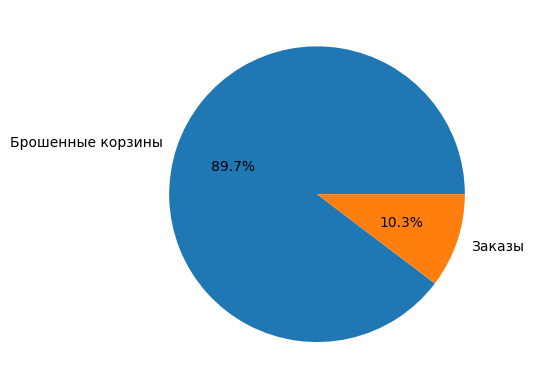

In [11]:
import matplotlib.pyplot as plt

# Значения для каждой категории
abandoned_carts = daily_data['Брошенные корзины'].sum()
orders = daily_data['Заказы'].sum()

# Названия категорий
categories = ['Брошенные корзины', 'Заказы']

# Значения для каждой категории
values = [abandoned_carts, orders]

# Создание круговой диаграммы
plt.pie(values, labels=categories, autopct='%1.1f%%')

# Отображение диаграммы
plt.show()


In [12]:
# Определение наиболее популярных страниц
popular_pages = df['request'].str.extract(r'\/([a-z]+)\.phtml')[0].value_counts()
print('Наиболее популярные страницы:')
print(popular_pages)

# Определение популярных товаров
popular_items = df[df['request'].str.contains('addbasket.phtml')]['request'].str.extract(r'id_book=(\d+)')[0].value_counts()
print('Наиболее популярные товары:')

total_unique_items = df[df['request'].str.contains('addbasket.phtml')]['request'].str.extract(r'id_book=(\d+)')[0].nunique()
print('Общее количество уникальных товаров:', total_unique_items)
popular_items

Наиболее популярные страницы:
0
search       107596
catalog      107216
addbasket     17134
order          1769
Name: count, dtype: int64
Наиболее популярные товары:
Общее количество уникальных товаров: 99


,count
0,
14,1223
11,1194
27,1191
2,1161
33,1148
...,...
36,92
78,91
21,91


In [14]:
pip install apyori

  Preparing metadata (setup.py) ... done
  Created wheel for apyori: filename=apyori-1.1.2-py3-none-any.whl size=5954 sha256=77bfa75501e9cbc7408c540e219f92b787c717cd683a9caf0c854e0589e55886
  Stored in directory: /root/.cache/pip/wheels/c4/1a/79/20f55c470a50bb3702a8cb7c94d8ada15573538c7f4baebe2d
Successfully built apyori


In [15]:
from apyori import apriori

df1 = df.copy()
df1['id_book'] = df1['request'].str.extract(r'id_book=(\d+)')
# Удаление пропущенных значений
df1 = df1.dropna(subset=['id_book'])

# Замена пропущенных значений
df1['id_book'] = df1['id_book'].fillna('missing')


# Группировка по id и создание списка книг для каждого id
transactions = df1.groupby('id')['id_book'].apply(list)

# Применение алгоритма Apriori
rules = apriori(transactions, min_support=0.01, min_confidence=0.5)

rules = list(apriori(transactions, min_support=0.01, min_confidence=0.5))

for rule in rules:
    pair = rule[0]
    items = [x for x in pair]
    print("Rule: " + items[0] + " -> " + items[1])
    print("Support: " + str(rule[1]))
    print("Confidence: " + str(rule[2][0][2]))
    print("Lift: " + str(rule[2][0][3]))
    print("=====================================")



<ipython-input-15-0fa1abc821f6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['id_book'] = df1['id_book'].fillna('missing')


Rule: 76 -> 11
Support: 0.013275613275613276
Confidence: 0.6690909090909092
Lift: 7.766834170854272
Rule: 23 -> 14
Support: 0.014574314574314575
Confidence: 0.6558441558441558
Lift: 7.432542927228127
Rule: 26 -> 2
Support: 0.013564213564213565
Confidence: 0.6438356164383562
Lift: 7.6860996070935546
Rule: 27 -> 65
Support: 0.012914862914862916
Confidence: 0.6605166051660516
Lift: 7.686616412763623
Rule: 33 -> 71
Support: 0.012987012987012988
Confidence: 0.6818181818181818
Lift: 8.23170731707317


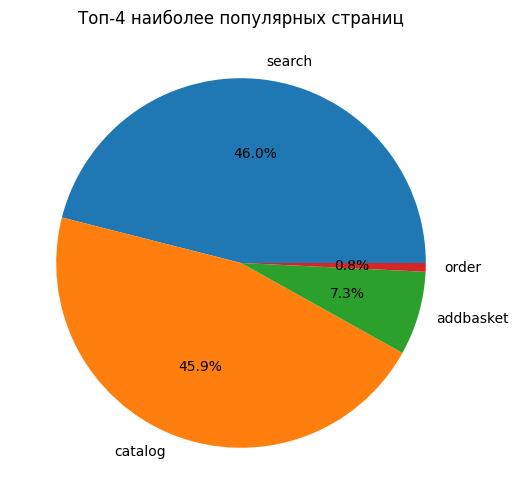

In [16]:
import matplotlib.pyplot as plt


top_pages = popular_pages.head(10)

# Создание круговой диаграммы
plt.figure(figsize=(10, 6))
plt.pie(top_pages, labels=top_pages.index, autopct='%1.1f%%')
plt.title('Топ-4 наиболее популярных страниц')
plt.show()


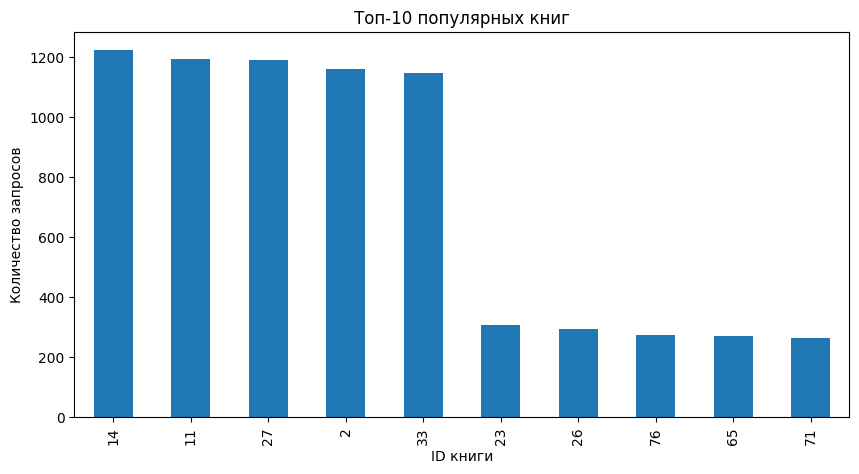

In [17]:
import matplotlib.pyplot as plt

# Извлечение идентификаторов книг из запросов
df['book_id'] = df['request'].str.extract('/addbasket.phtml\?id_book=(\d+)', expand=False)

# Подсчет количества запросов для каждой книги
book_counts = df['book_id'].value_counts()

# Получение топ-10 популярных книг
top_books = book_counts.head(10)

# Создание диаграммы
plt.figure(figsize=(10, 5))
top_books.plot(kind='bar')
plt.title('Топ-10 популярных книг')
plt.xlabel('ID книги')
plt.ylabel('Количество запросов')
plt.show()


Уникальные пользователи: 49546
Всего запросов: 233715
Запросов с ошибками: 0


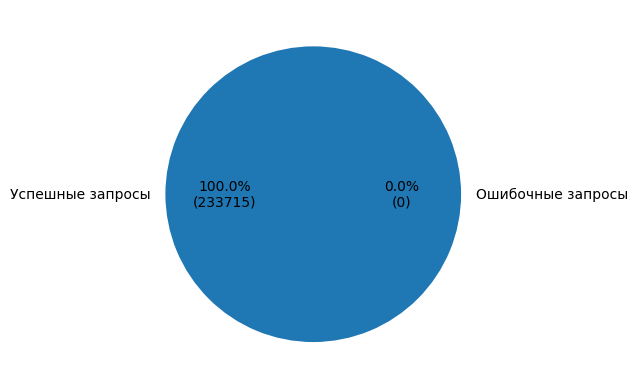

In [ ]:
unique_users = df['id'].nunique()

total_requests = df.shape[0]

error_requests = df[df['status'] != '200'].shape[0]

print(f'Уникальные пользователи: {unique_users}')
print(f'Всего запросов: {total_requests}')
print(f'Запросов с ошибками: {error_requests}')

# Названия категорий
categories = ['Успешные запросы', 'Ошибочные запросы']

# Значения для каждой категории
values = [total_requests - error_requests, error_requests]

# Создание круговой диаграммы
fig, ax = plt.subplots()
ax.pie(values, labels=categories, autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p,(p/100)*sum(values)))

# Отображение диаграммы
plt.show()

In [ ]:
total_visitors = daily_data['Посетители'].sum()
bounce_rate = daily_data['Показатель отказа'].sum()
ans = (bounce_rate / total_visitors) * 100
ans


20.55261776934566

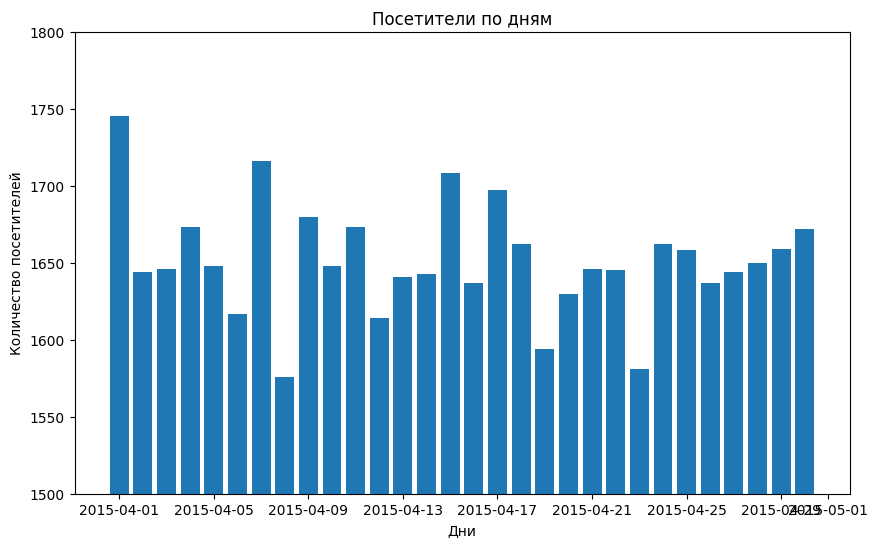

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(daily_data.index, daily_data['Посетители'])
plt.title('Посетители по дням')
plt.xlabel('Дни')
plt.ylabel('Количество посетителей')
plt.ylim(1500, 1800)
plt.show()


In [ ]:
# Преобразование строки даты и времени в объект datetime
df['datetime'] = pd.to_datetime(df['date'], format='%d/%b/%Y:%H:%M:%S %z')

# Извлечение часа из даты и времени
df['hour'] = df['datetime'].dt.hour

# Определение временного интервала на основе часа
df['time_of_day'] = pd.cut(df['hour'], bins=[0, 6, 12, 18, 24], labels=['Ночь', 'Утро', 'День', 'Вечер'], include_lowest=True)

# Анализ активности пользователей в каждом временном интервале
time_of_day_counts = df['time_of_day'].value_counts().sort_index()
time_of_day_counts

Ночь     67639
Утро     57983
День     59648
Вечер    48445
Name: time_of_day, dtype: int64

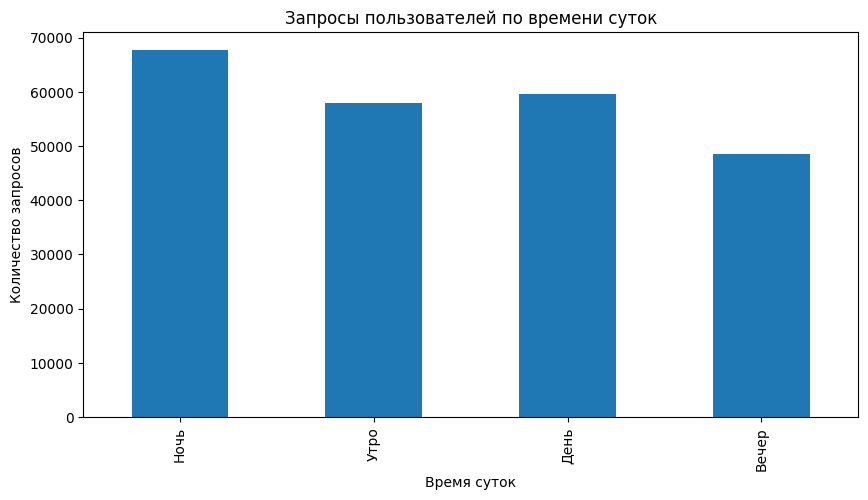

In [ ]:
import matplotlib.pyplot as plt

# Подсчет количества записей в каждом временном интервале
time_of_day_counts = df['time_of_day'].value_counts().sort_index()

# Создание диаграммы
plt.figure(figsize=(10, 5))
time_of_day_counts.plot(kind='bar')
plt.title('Запросы пользователей по времени суток')
plt.xlabel('Время суток')
plt.ylabel('Количество запросов')
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                       Просмотры     Поиск    Заказы   Корзина   Каталог  \
Просмотры               1.000000  0.923686  0.519691  0.725790  0.920703   
Поиск                   0.923686  1.000000  0.246474  0.568094  0.725229   
Заказы                  0.519691  0.246474  1.000000  0.730548  0.589254   
Корзина                 0.725790  0.568094  0.730548  1.000000  0.624084   
Каталог                 0.920703  0.725229  0.589254  0.624084  1.000000   
Брошенные корзины       0.696417  0.616153  0.489604  0.953097  0.535716   
Не завершенные заказы   0.999308  0.933217  0.487544  0.709899  0.915242   
Посетители              0.702787  0.628166  0.420939  0.528136  0.661820   
Конверсия заказов       0.439799  0.162951  0.990234  0.687860  0.520018   
Визиты                  0.729941  0.635388  0.499436  0.491189  0.717947   
Глубина просмотра       0.498924  0.507664  0.109673  0.406241  0.405206   
Показатель отказа      -0.168804 -0.216305  0.105783 -0.035508 -0.126026   

           

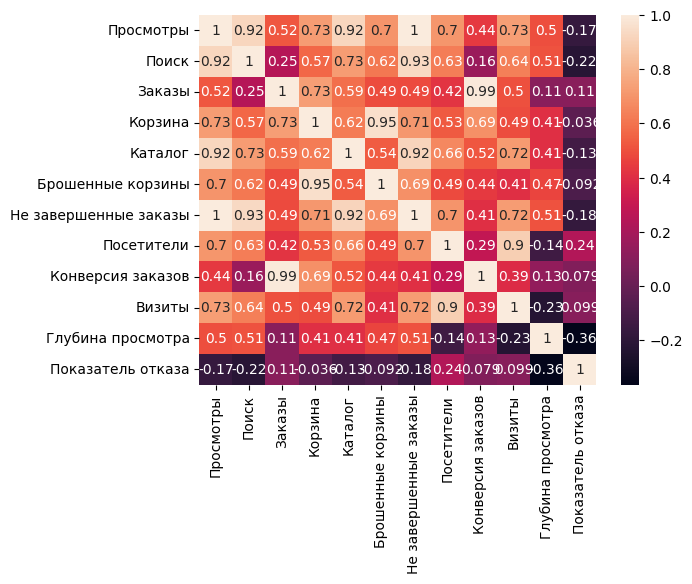

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Расчет корреляционной матрицы
corr_matrix = daily_data.corr()

# Вывод корреляционной матрицы
print(corr_matrix)

# Визуализация корреляционной матрицы
sns.heatmap(corr_matrix, annot=True)
plt.show()


# Проверка гипотез

Гипотеза 1. Посещения страницы поиска и каталога наиболее часто встречающиеся действия, которые пользователи выполняют вместе

In [ ]:
from apyori import apriori

# Создание списка действий для каждого пользователя
actions_per_user = df.groupby('id')['request'].apply(list)

# Применение алгоритма Apriori
rules = apriori(actions_per_user, min_support=0.6)

# Преобразование результатов в список для удобства чтения
results = list(rules)


# Создание пустого DataFrame
results_df = pd.DataFrame(columns=['actions', 'support'])

# Заполнение DataFrame результатами
for result in results:
    actions = ', '.join(result.items)
    support = result.support
    temp_df = pd.DataFrame({'actions': [actions], 'support': [support]})
    results_df = pd.concat([results_df, temp_df], ignore_index=True)

# Вывод DataFrame
print(results_df)


                                             actions   support
0                       POST /catalog.phtml HTTP 1.1  0.818310
1                        POST /search.phtml HTTP 1.1  0.814919
2  POST /catalog.phtml HTTP 1.1, POST /search.pht...  0.633250


id
ID10000                        [POST /search.phtml HTTP 1.1]
ID10001    [POST /catalog.phtml HTTP 1.1, POST /search.ph...
ID10002    [POST /catalog.phtml HTTP 1.1, POST /catalog.p...
ID10003    [POST /search.phtml HTTP 1.1, POST /catalog.ph...
ID10004                       [POST /catalog.phtml HTTP 1.1]
                                 ...                        
ID9995                         [POST /search.phtml HTTP 1.1]
ID9996                         [POST /search.phtml HTTP 1.1]
ID9997                        [POST /catalog.phtml HTTP 1.1]
ID9998     [POST /search.phtml HTTP 1.1, POST /catalog.ph...
ID9999     [POST /catalog.phtml HTTP 1.1, POST /catalog.p...
Name: request, Length: 49546, dtype: object

Проверка на устойчивость

In [ ]:
from sklearn.model_selection import train_test_split
from apyori import apriori
import pandas as pd
import numpy as np
import random

# Создание списка действий для каждого пользователя
actions_per_user = df.groupby('id')['request'].apply(list)

# Разделение данных на обучающую и тестовую выборки
train, test = train_test_split(actions_per_user, test_size=0.2, random_state=42)

# Применение алгоритма Apriori к обучающей выборке
rules_train = apriori(train, min_support=0.6)
results_train = list(rules_train)

# Применение алгоритма Apriori к тестовой выборке
rules_test = apriori(test, min_support=0.6)
results_test = list(rules_test)




In [ ]:
# Создание пустого DataFrame для обучающих данных
results_train_df = pd.DataFrame(columns=['actions', 'support'])

# Заполнение DataFrame результатами
for result in results_train:
    actions = ', '.join(result.items)
    support = result.support
    temp_df = pd.DataFrame({'actions': [actions], 'support': [support]})
    results_train_df = pd.concat([results_train_df, temp_df], ignore_index=True)

# Вывод DataFrame для обучающих данных
print("Результаты обучающейся выборки")
print(results_train_df)

# Создание пустого DataFrame для тестовых данных
results_test_df = pd.DataFrame(columns=['actions', 'support'])

# Заполнение DataFrame результатами
for result in results_test:
    actions = ', '.join(result.items)
    support = result.support
    temp_df = pd.DataFrame({'actions': [actions], 'support': [support]})
    results_test_df = pd.concat([results_test_df, temp_df], ignore_index=True)

# Вывод DataFrame для тестовых данных
print("\nРезультаты тестовой выборки:")
print(results_test_df)




Результаты обучающейся выборки
                                             actions   support
0                       POST /catalog.phtml HTTP 1.1  0.819129
1                        POST /search.phtml HTTP 1.1  0.815673
2  POST /catalog.phtml HTTP 1.1, POST /search.pht...  0.634827

Результаты тестовой выборки:
                                             actions   support
0                       POST /catalog.phtml HTTP 1.1  0.815035
1                        POST /search.phtml HTTP 1.1  0.811907
2  POST /catalog.phtml HTTP 1.1, POST /search.pht...  0.626942


Проверка на случайность

In [ ]:
import random

# Создание копии данных
shuffled_actions_per_user = actions_per_user.copy()

# Перемешивание действий для каждого пользователя
for actions in shuffled_actions_per_user:
    random.shuffle(actions)

# Применение алгоритма Apriori к перемешанным данным
shuffled_rules = apriori(shuffled_actions_per_user, min_support=0.6)

# Преобразование результатов в список для удобства чтения
shuffled_results = list(shuffled_rules)

# Создание пустого DataFrame
shuffled_results_df = pd.DataFrame(columns=['actions', 'support'])

# Заполнение DataFrame результатами
for result in shuffled_results:
    actions = ', '.join(result.items)
    support = result.support
    temp_df = pd.DataFrame({'actions': [actions], 'support': [support]})
    shuffled_results_df = pd.concat([shuffled_results_df, temp_df], ignore_index=True)

# Вывод DataFrame
print(shuffled_results_df)

                                             actions   support
0                       POST /catalog.phtml HTTP 1.1  0.818310
1                        POST /search.phtml HTTP 1.1  0.814919
2  POST /catalog.phtml HTTP 1.1, POST /search.pht...  0.633250


2.	Большинство запросов на просмотр поиска не приводят к добавлению товаров в корзину;

Ежедневный процент запросов на поиск: 46.03571502989403%
Ежедневный процент запросов на добавление в корзину: 7.330107530485026%


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


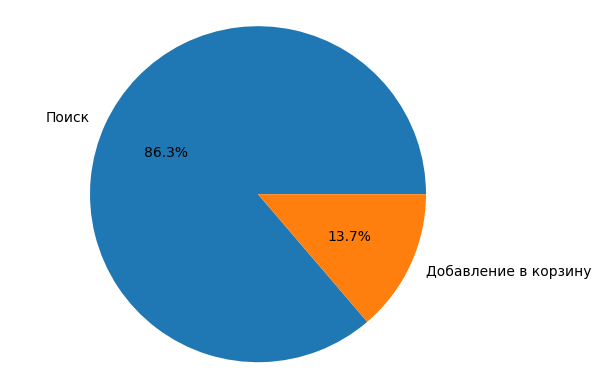

In [ ]:
# Подсчет количества запросов на поиск и добавление в корзину за каждый день
search_requests_daily = daily_data['Поиск']
add_to_basket_requests_daily = daily_data['Корзина']

# Вычисление процентного соотношения
search_percentage_daily = search_requests_daily / daily_data['Просмотры'] * 100
add_to_basket_percentage_daily = add_to_basket_requests_daily / daily_data['Просмотры'] * 100

print(f"Ежедневный процент запросов на поиск: {search_percentage_daily.mean()}%")
print(f"Ежедневный процент запросов на добавление в корзину: {add_to_basket_percentage_daily.mean()}%")

# Визуализация результатов
labels = ['Поиск', 'Добавление в корзину']
sizes = [search_percentage_daily.mean(), add_to_basket_percentage_daily.mean()]
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.axis('equal')
plt.show()



3.	Большинство запросов на просмотр каталога не приводят к добавлению товаров в корзину;

Ежедневный процент запросов на просмотр каталога: 45.8782299851837%
Ежедневный процент запросов на добавление в корзину: 7.330107530485026%


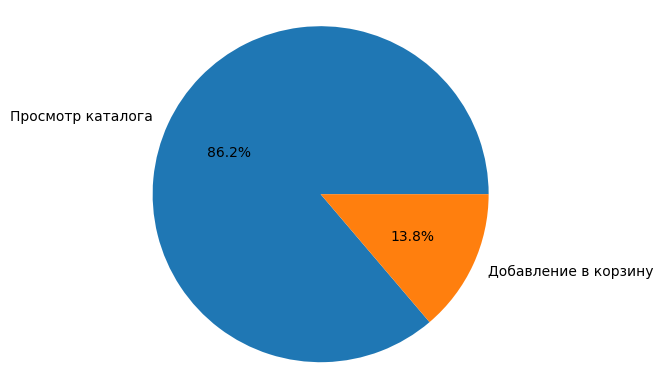

In [ ]:
# Подсчет количества запросов на просмотр каталога и добавление в корзину за каждый день
catalog_requests_daily = daily_data['Каталог']
add_to_basket_requests_daily = daily_data['Корзина']

# Вычисление процентного соотношения
catalog_percentage_daily = catalog_requests_daily / daily_data['Просмотры'] * 100
add_to_basket_percentage_daily = add_to_basket_requests_daily / daily_data['Просмотры'] * 100

print(f"Ежедневный процент запросов на просмотр каталога: {catalog_percentage_daily.mean()}%")
print(f"Ежедневный процент запросов на добавление в корзину: {add_to_basket_percentage_daily.mean()}%")

# Визуализация результатов
labels = ['Просмотр каталога', 'Добавление в корзину']
sizes = [catalog_percentage_daily.mean(), add_to_basket_percentage_daily.mean()]
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.axis('equal')
plt.show()


4.	Большинство посетителей просматривают больше одной страницы за визит;

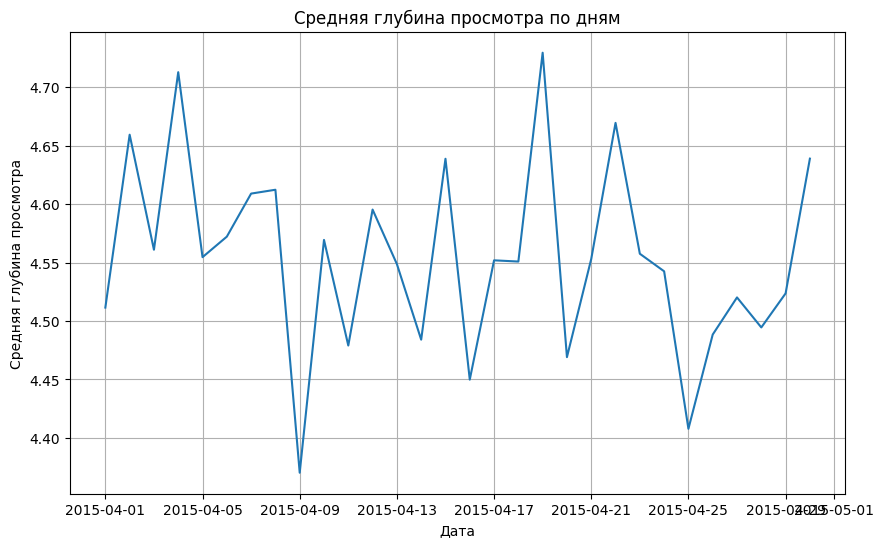

In [ ]:
import matplotlib.pyplot as plt

# Визуализация средней глубины просмотра
plt.figure(figsize=(10, 6))
plt.plot(daily_data.index, daily_data['Глубина просмотра'])
plt.xlabel('Дата')
plt.ylabel('Средняя глубина просмотра')
plt.title('Средняя глубина просмотра по дням')
plt.grid(True)
plt.show()


5.	Время суток влияет на активность посетителей;

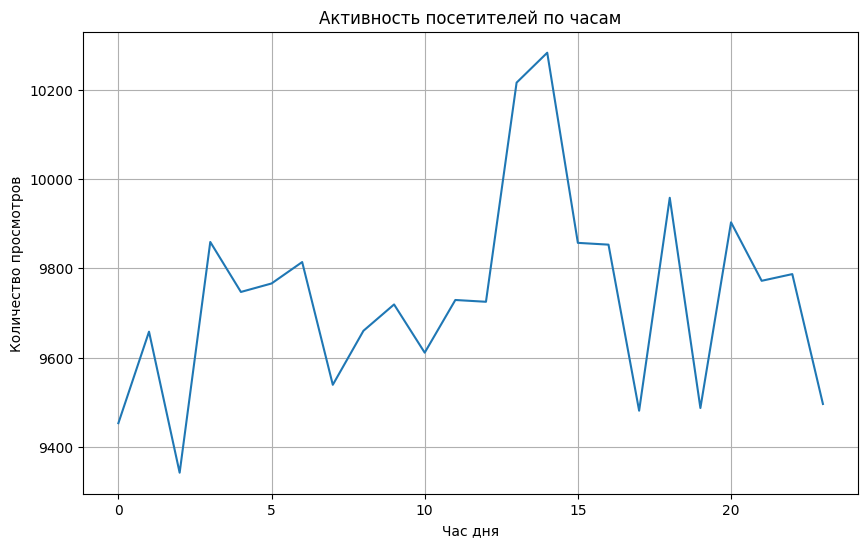

In [ ]:
import matplotlib.pyplot as plt

# Подсчет количества просмотров за каждый час
views_hourly = hour_data['Просмотры']

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(views_hourly.index, views_hourly.values)
plt.xlabel('Час дня')
plt.ylabel('Количество просмотров')
plt.title('Активность посетителей по часам')
plt.grid(True)
plt.show()



6.	День недели влияет на количество посетителей;

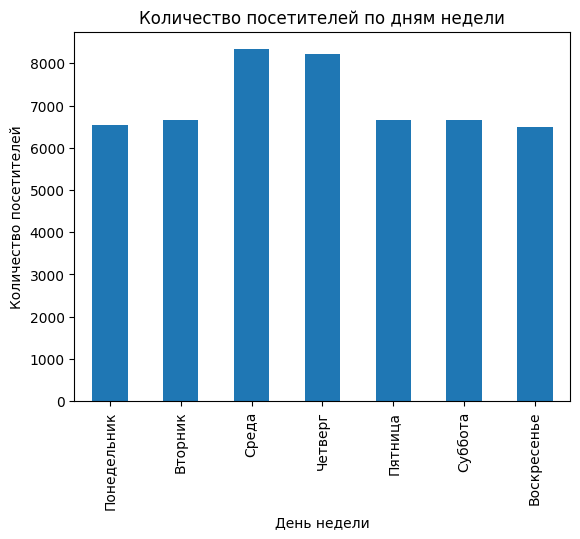

In [ ]:
import matplotlib.pyplot as plt

# Создание нового фигуры и осей
fig, ax = plt.subplots()

# Визуализация данных
users_by_weekday['Посетители'].plot(kind='bar', ax=ax)

# Установка заголовка и меток осей
ax.set_title('Количество посетителей по дням недели')
ax.set_xlabel('День недели')
ax.set_ylabel('Количество посетителей')

# Показать график
plt.show()


7.	День недели влияет на кол-во просмотров

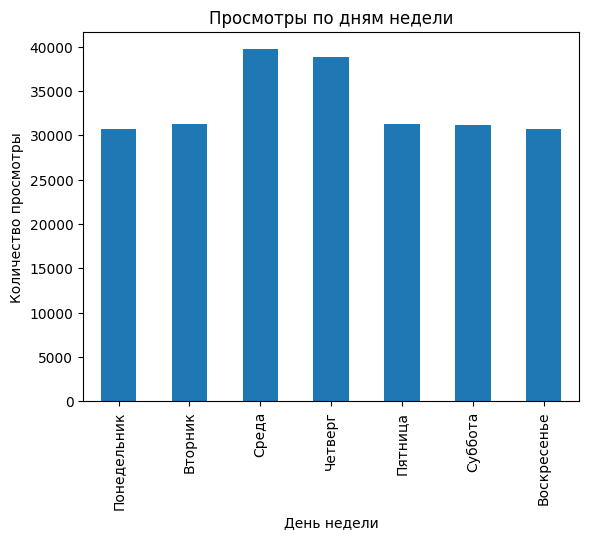

In [ ]:
import matplotlib.pyplot as plt

# Создание нового фигуры и осей
fig, ax = plt.subplots()

# Визуализация данных
users_by_weekday['Просмотры'].plot(kind='bar', ax=ax)

# Установка заголовка и меток осей
ax.set_title('Просмотры по дням недели')
ax.set_xlabel('День недели')
ax.set_ylabel('Количество просмотры')

# Показать график
plt.show()

8.	Признак-столбец посетителей не нормально распределён;

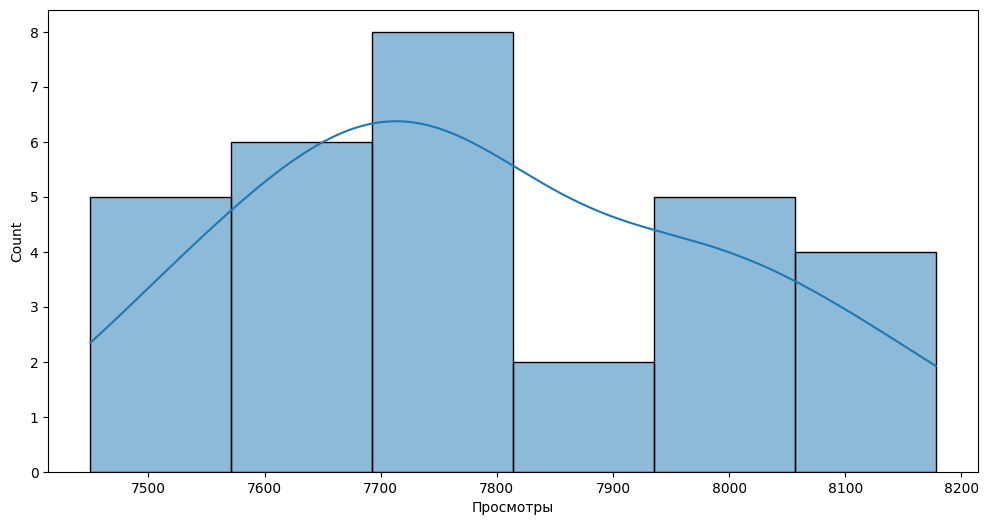

Skewness:  0.26983189226375764
Kurtosis:  -0.8538832203348261


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.histplot(daily_data['Просмотры'], kde=True)
plt.show()
from scipy.stats import skew, kurtosis

print('Skewness: ', skew(daily_data['Просмотры']))
print('Kurtosis: ', kurtosis(daily_data['Просмотры']))


9. Между количеством поисковых запросов и вероятностью оформления заказа, существует низкая корреляция.

Корреляция между количеством поисковых запросов и количеством заказов: 0.342932033168788


<Axes: xlabel='Поиск', ylabel='Заказы'>

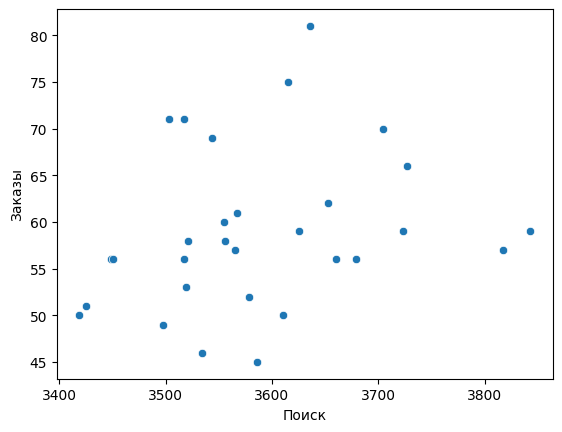

In [ ]:
import seaborn as sns
from scipy.stats import spearmanr
corr, p = spearmanr(daily_data['Поиск'],daily_data['Заказы'])

print(f"Корреляция между количеством поисковых запросов и количеством заказов: {corr}")

sns.scatterplot(x='Поиск', y='Заказы', data=daily_data)





10.	Разброс показателя посетители в днях в пределах 100 человек

In [ ]:
print(sds["Посетители"])

count         30.000000
mean        1651.533333
std           36.446213
min         1576.000000
25%         1638.000000
50%         1647.000000
75%         1669.500000
max         1745.000000
variance    1328.326437
Name: Посетители, dtype: float64


11.	Корреляция между каталогом и посетителем высокая.

Корреляция между количеством поисковых запросов и количеством заказов: 0.6993988669487621


<Axes: xlabel='Каталог', ylabel='Посетители'>

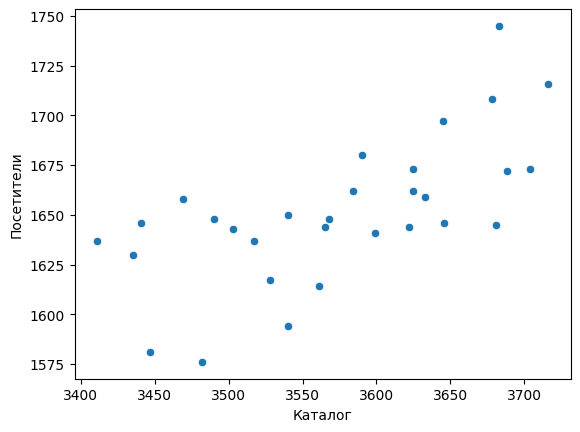

In [ ]:
import seaborn as sns
from scipy.stats import spearmanr
corr, p = spearmanr(daily_data['Каталог'],daily_data['Посетители'])

print(f"Корреляция между количеством поисковых запросов и количеством заказов: {corr}")

sns.scatterplot(x='Каталог', y='Посетители', data=daily_data)